In [1]:
%matplotlib inline 
import numpy as np 
import scipy as sp 
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# 1. Nhập dữ liệu

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
full_data = pd.concat([train,test])

# 2. Khảo sát tập dữ liệu

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_num = train[['Age','SibSp','Parch','Fare']]
df_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

## 2.1) Trực quan hóa dữ liệu

0    549
1    342
Name: Survived, dtype: int64

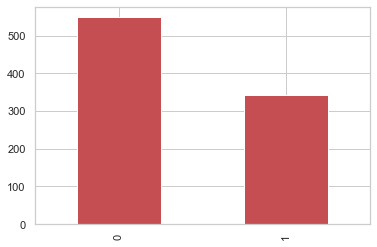

In [6]:
train["Survived"].value_counts().plot(kind="bar",color ='r')
train["Survived"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

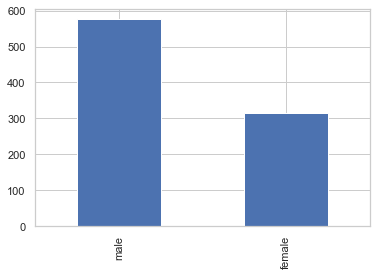

In [7]:
train["Sex"].value_counts().plot(kind="bar")
train["Sex"].value_counts()

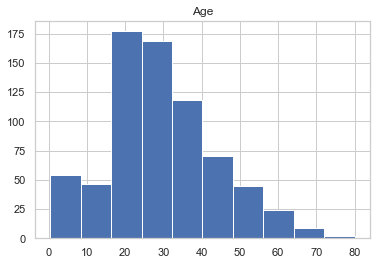

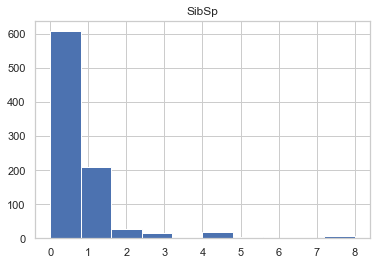

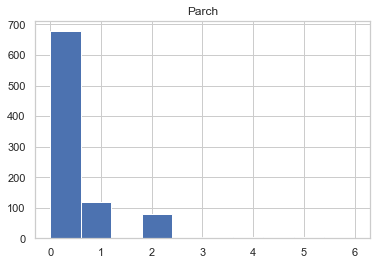

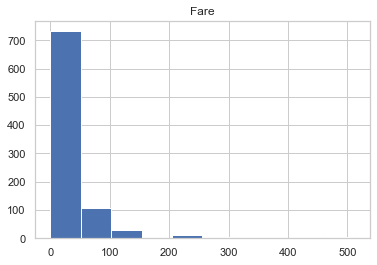

In [8]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

In [9]:
def survival_stacked_bar(variable):
    Died=train[train["Survived"]==0][variable].value_counts()/len(train["Survived"]==0)
    Survived=train[train["Survived"]==1][variable].value_counts()/len(train["Survived"]==1)
    data=pd.DataFrame([Died,Survived])
    data.index=["Dead","Survived"]
    data.plot(kind="bar",stacked=True,title="Percentage")
    return data.head()

,male,female
Dead,0.525253,0.090909
Survived,0.122334,0.261504


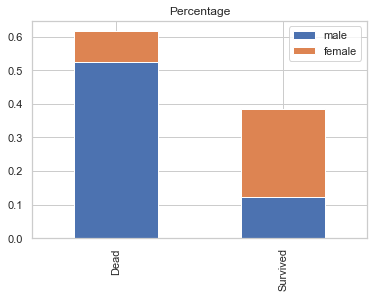

In [10]:
survival_stacked_bar("Sex")

,1,2,3
Dead,0.089787,0.108866,0.417508
Survived,0.152637,0.097643,0.133558


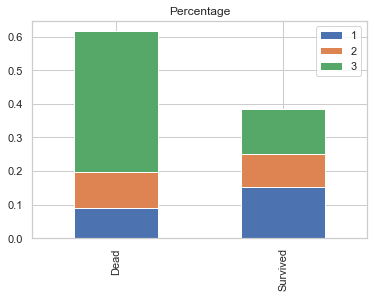

In [11]:
survival_stacked_bar("Pclass")

,S,C,Q
Dead,0.479237,0.084175,0.05275
Survived,0.243547,0.104377,0.03367


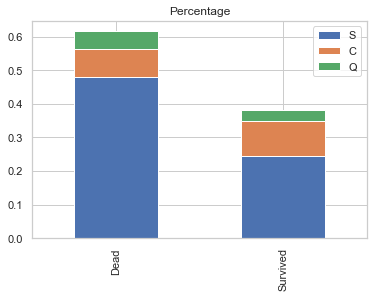

In [12]:
survival_stacked_bar("Embarked")

In [13]:
print(pd.pivot_table(train, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


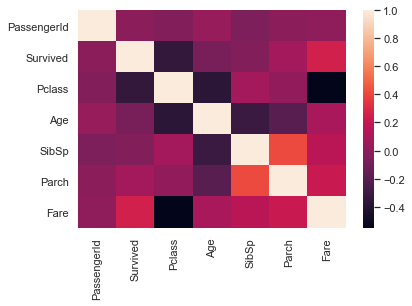

In [14]:
sns.heatmap(train.corr())
train.corr()

## 2.2) Xử lý missing value

In [15]:
for i in train.columns:
    print (i + ": "+str(sum(train[i].isnull()))+" missing values")

PassengerId: 0 missing values
Survived: 0 missing values
Pclass: 0 missing values
Name: 0 missing values
Sex: 0 missing values
Age: 177 missing values
SibSp: 0 missing values
Parch: 0 missing values
Ticket: 0 missing values
Fare: 0 missing values
Cabin: 687 missing values
Embarked: 2 missing values


In [16]:
train_set_1=train.groupby(["Pclass","Sex"])
train_set_1_median=train_set_1.median()
train_set_1_median

PassengerId  Survived   Age  SibSp  Parch      Fare
Pclass Sex                                                        
1      female        447.0       1.0  35.0    0.0    0.0  82.66455
       male          480.5       0.0  40.0    0.0    0.0  41.26250
2      female        439.5       1.0  28.0    0.0    0.0  22.00000
       male          416.5       0.0  30.0    0.0    0.0  13.00000
3      female        376.0       0.5  21.5    0.0    0.0  12.47500
       male          466.0       0.0  25.0    0.0    0.0   7.92500

In [17]:
def fill_age(dataset,dataset_med):
    for x in range(len(dataset)):
        if dataset["Pclass"][x]==1:
            if dataset["Sex"][x]=='female':
                return dataset_med.loc[1,'female']["Age"]
            elif dataset["Sex"][x]=='male':
                return dataset_med.loc[1,'male']["Age"]
            
        elif dataset["Pclass"][x]==2:
            if dataset["Sex"][x]=='female':
                return dataset_med.loc[2,'female']["Age"]
            elif dataset["Sex"][x]=='male':
                return dataset_med.loc[2,'male']["Age"]
            
        elif dataset["Pclass"][x]==3:
            if dataset["Sex"][x]=='female':
                return dataset_med.loc[3,'female']["Age"]
            elif dataset["Sex"][x]=='male':
                return dataset_med.loc[3,'male']["Age"]

In [18]:
train["Age"]=train["Age"].fillna(fill_age(train,train_set_1_median))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [19]:
test_set_1=test.groupby(["Pclass","Sex"])
test_set_1_median=test_set_1.median()
test["Cabin"]=test["Cabin"].fillna("U")
test["Age"]=test["Age"].fillna(fill_age(test,test_set_1_median))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [20]:
train["Cabin"]=train["Cabin"].fillna("U")
sex_map={"male":1,"female":0}
train["Sex"]=train["Sex"].map(sex_map)
test["Sex"]=test["Sex"].map(sex_map)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


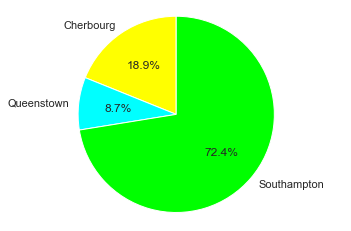

In [21]:
labels="Cherbourg","Queenstown","Southampton"
sizes=[sum(train["Embarked"]=="C"),sum(train["Embarked"]=="Q"),sum(train["Embarked"]=="S")]
colors=["yellow","aqua","lime"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

In [22]:
train["Embarked"]=train["Embarked"].fillna("S")
test["Embarked"]=test["Embarked"].fillna("S")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


# Model building

In [23]:
train.drop(["Name","Ticket","PassengerId","Embarked","Cabin"],inplace=True,axis=1)
y=train["Survived"]
x=train.drop(["Survived"],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [24]:
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Dead","Predicted Survived"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Dead","Predicted Survived"]
    cm.index=["Actual Dead","Actual Survived"]
    cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2)
    return cm

In [25]:
def evaluation(confusion_matrix):
    r = confusion_matrix.loc['Actual Survived', 'Predicted Survived']/np.sum(confusion_matrix.loc['Actual Survived'])
    p = confusion_matrix.loc['Actual Survived', 'Predicted Survived']/(confusion_matrix.loc['Actual Survived', 'Predicted Survived'] + confusion_matrix.loc['Actual Dead', 'Predicted Survived'])
    f1=2*p*r/(p+r)
    return (p,r,f1)

In [26]:
SVC_rbf=SVC(kernel="rbf")
SVC_rbf.fit(x_train,y_train)
p,r,f1 = evaluation(confusion_matrix_model(SVC_rbf))
print("Recall: " + str(r) + "   Precision: " + str(p)+"   F1: " + str(f1))
confusion_matrix_model(SVC_rbf)

Recall: 0.36   Precision: 0.8780487804878049   F1: 0.5106382978723404


,Predicted Dead,Predicted Survived
Actual Dead,0.95,0.05
Actual Survived,0.64,0.36


In [27]:
KNN=KNeighborsClassifier(n_neighbors=5)
KNN.fit(x_train,y_train)
p,r,f1 = evaluation(confusion_matrix_model(KNN))
print("Recall: " + str(r) + "   Precision: " + str(p)+"   F1: " + str(f1))
confusion_matrix_model(KNN)

Recall: 0.62   Precision: 0.7948717948717948   F1: 0.6966292134831461


,Predicted Dead,Predicted Survived
Actual Dead,0.84,0.16
Actual Survived,0.38,0.62


In [28]:
Dec_tree=DecisionTreeClassifier(max_depth=4,random_state=5)
Dec_tree.fit(x_train,y_train)
p,r,f1 = evaluation(confusion_matrix_model(Dec_tree))
print("Recall: " + str(r) + "   Precision: " + str(p)+"   F1: " + str(f1))
confusion_matrix_model(Dec_tree)

Recall: 0.67   Precision: 0.8933333333333334   F1: 0.7657142857142858


,Predicted Dead,Predicted Survived
Actual Dead,0.92,0.08
Actual Survived,0.33,0.67


In [29]:
ranfor = RandomForestClassifier(n_estimators=50, max_features='sqrt',max_depth=6,random_state=10)
ranfor = ranfor.fit(x_train,y_train)
p,r,f1 = evaluation(confusion_matrix_model(ranfor))
print("Recall: " + str(r) + "   Precision: " + str(p)+"   F1: " + str(f1))
confusion_matrix_model(ranfor)

Recall: 0.7   Precision: 0.8860759493670887   F1: 0.7821229050279329


,Predicted Dead,Predicted Survived
Actual Dead,0.91,0.09
Actual Survived,0.30,0.70


In [30]:
test.drop(["Name","Ticket","Embarked","Cabin"],inplace=True,axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         417 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


In [31]:
test["Fare"]=test["Fare"].fillna("363272")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 23.0+ KB


In [32]:
pred_test=Dec_tree.predict(test.drop("PassengerId",axis=1).copy())
submission=pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": pred_test})
submission.to_csv("submission.csv",index=False)